In [1]:
from pymongo import MongoClient
from elasticsearch import Elasticsearch, helpers
import requests
from IPython.display import JSON
import numpy as np
from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import math
from thefuzz import fuzz, process
import re
from IPython.display import clear_output, display
import json
from unidecode import unidecode
from colavsim import colav_similarity, parse_doi, parse_string

In [2]:
es = Elasticsearch(timeout=120)

In [3]:
# open a file, where you stored the pickled data
file = open('dataset_full.pkl', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()

In [4]:
len(data["p"])

101773

In [5]:
len(data["n"])

41596

In [6]:
data["p"][0]

{'Authors': 'Jaramillo-Ayerbe F., Berrío-Muñoz J.',
 'Title': 'Ivermectin for crusted Norwegian scabies induced by use of topical steroids',
 'Year': 1998,
 'Source title': 'Archives of Dermatology',
 'Volume': '134',
 'Issue': '2',
 'Page start': '143',
 'Page end': '145',
 'DOI': '10.1001/archderm.134.2.143'}

In [7]:
data["n"][0]

{'Authors': 'Flórez G.A.D., Mombello E.E., Voss S.',
 'Title': 'Novel technique for the calculation of eddy current losses and Lorentz forces in foil winding transformers',
 'Year': 2017,
 'Source title': 'International Journal of Applied Electromagnetics and Mechanics',
 'Volume': '55',
 'Issue': '1',
 'Page start': '75',
 'Page end': '88',
 'DOI': '10..3233/JAE-160144'}

In [8]:
scopus = []
#np.random.shuffle(data["p"])
#np.random.shuffle(data["n"])
for i in data["p"][0:3001]:
    scopus.append((i,True))
for i in data["n"][0:3000]:
    scopus.append((i,False))

In [66]:
es_index = list(es.indices.get_alias("*").keys())
es_index.remove("openalex_raw")
es_index.remove("oa_dfr")
es_index

/tmp/ipykernel_455605/1118372514.py:1: DeprecationWarning: Using positional arguments for APIs is deprecated and will be disabled in 8.0.0. Instead use only keyword arguments for all APIs. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es_index = list(es.indices.get_alias("*").keys())


['openalex_parsed']

In [10]:
def get_oa_doi(es_reg):
    for i in es_reg["_source"]['external_ids']:
        if i['source'] == "doi":
            return i["id"]


def get_oa_doi(es_reg):
    return es_reg["_source"]['doi']


In [386]:
def search(Title, Authors, Source, Year, Volume, Issue, PageStart, PageEnd, punto_de_corte = 0):
    """
    Definir el valor mínimo del _score que deseas
    Puedes ajustar este valor según tus necesidades

    """
    if not isinstance(Title, str):
        Title = ""
    if not isinstance(Source, str):
        Source = ""
    if not isinstance(Volume, str) or not isinstance(Volume, int):
        Volume = ""
    if not isinstance(Issue, str) or not isinstance(Issue, int):
        Issue = ""
    if not isinstance(PageStart, str) or not isinstance(PageStart, int):
        PageStart = ""
    if not isinstance(PageEnd, str) or not isinstance(PageEnd, int):
        PageEnd = ""
        
    body = {
        "query": {
            "bool": {
                "should": [
                     { "match": { "title": Title}},
                    #{ "match_phrase": { "title": { "query": Title, "boost": 2 }}},
                    { "match": { "authorships.author.display_name":  Authors }},
                    { "match": { "host_venue.display_name":  Source}},
                    { "term": { "publication_year": Year }},
                    { "term": { "biblio.volume": Volume }},
                    { "term": { "biblio.issue": Issue }},
                    { "term": { "biblio.first_page": PageStart }},
                    { "term": { "biblio.last_page": PageEnd }},
                    
                ] ,
                # "must": [
                #      { "match": { "title": Title}},
                #     #{ "match_phrase": { "title": { "query": Title, "boost": 2 }}},
                #     # { "match": { "authorships.author.display_name":  Authors }},
                #     { "match": { "host_venue.display_name":  Source}},
                #     # { "term": { "publication_year": Year }},
                #     # { "term": { "biblio.volume": Volume }},
                #     # { "term": { "biblio.issue": Issue }},
                #     # { "term": { "biblio.first_page": PageStart }},
                #     # { "term": { "biblio.last_page": PageEnd }},
                    
                # ]                  
            }
        },
        "size": 10,
        "min_score": punto_de_corte
    }
    
    res = es.search(index=es_index, **body)
    return  res

In [348]:
def parse_string(string:str):
    data = str(string).lower()
    data = re.sub(r'<[^>]+>','',data)
    data = unidecode(data)
    return data    
print(scopus[0][0]["Title"])
def parse_doi(doi):
    
    return re.sub(r'https*\:\/\/[\w\.]+\/','',str(doi).lower())

Evaluation of greenhouses in fish production [Evaluación de invernaderos en producciones piscícolas]


In [349]:
parse_string(scopus[0][0]["Title"])

'evaluation of greenhouses in fish production [evaluacion de invernaderos en producciones piscicolas]'

In [350]:
scopus[0][0]['Authors']

'Hahn-von-Hessberg C.M., Grajales-Quintero A.'

In [439]:
%%time
#ratio_thold=90, partial_thold=90,low_thold=85) #3000 / fn = 26
#ratio_thold=95, partial_thold=90,low_thold=80 #3000 / fn = 25
#ratio_thold=90, partial_thold=90,low_thold=80 #3000 / fn = 24
def es_similarity(rec,th = 0):
    res = search(parse_string(rec['Title']),rec['Authors'],rec['Source title'],rec['Year'],
                 rec['Volume'], rec['Issue'], rec['Page start'], rec['Page end'],0)
    if res["hits"]["total"]["value"] != 0:
        _score = res["hits"]["hits"][0]["_score"]
        # i = res["hits"]["hits"][0]
        # value = colav_similarity(rec['Title']       ,  i["_source"]['title'],
        #                         rec['Source title'],  i["_source"]["host_venue"]["display_name"],
        #                         rec['Year']        ,  i["_source"]['publication_year'],
        #                         ratio_thold=90, partial_thold=90,low_thold=80)
        # return (value,i["_score"])
# #                      
#         for i in res["hits"]["hits"]:
#            if  colav_similarity(rec['Title']       ,  i["_source"]['title'],
#                                 rec['Source title'],  i["_source"]["host_venue"]["display_name"],
#                                 rec['Year']        ,  i["_source"]['publication_year'],
#                                 ratio_thold=95, partial_thold=95,low_thold=95):
#                return (True,i["_score"])
# #                                ratio_thold=95, partial_thold=95,low_thold=95)
#         return (False,_score)
        if _score >= th:
            return (True,_score)
        else:
            i = res["hits"]["hits"][0]
            value = colav_similarity(rec['Title']       ,  i["_source"]['title'],
                                    rec['Source title'],  i["_source"]["host_venue"]["display_name"],
                                    rec['Year']        ,  i["_source"]['publication_year'],
                                    ratio_thold=90, partial_thold=95,low_thold=80)
            return (value,i["_score"])

        # oa_doi = re.sub(r'https*\:\/\/[\w\.]+\/','',get_oa_doi(res["hits"]["hits"][0]).lower())
        # sc_doi = re.sub(r'https*\:\/\/[\w\.]+\/','',rec["DOI"].lower())
        # if oa_doi == sc_doi:
        #     return (True,_score)
        # else:
        #     return (False,_score)
        # return (True,_score)
    else:
        return (False,0)
scopus = []
np.random.shuffle(data["p"])
np.random.shuffle(data["n"])
for i in data["p"][0:10000]:
    scopus.append((i,True))
for i in data["n"][0:10000]:
    scopus.append((i,False))
np.random.shuffle(scopus) #shuffle is inplace
th=100
results = Parallel(n_jobs=15,backend='threading',verbose=2)(delayed(es_similarity)(rec[0],th) for rec in scopus)

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:    2.7s
[Parallel(n_jobs=15)]: Done 335 tasks      | elapsed:    8.2s
[Parallel(n_jobs=15)]: Done 618 tasks      | elapsed:   14.5s
[Parallel(n_jobs=15)]: Done 983 tasks      | elapsed:   24.4s
[Parallel(n_jobs=15)]: Done 1428 tasks      | elapsed:   36.1s
[Parallel(n_jobs=15)]: Done 1955 tasks      | elapsed:   46.2s
[Parallel(n_jobs=15)]: Done 2562 tasks      | elapsed:  1.0min
[Parallel(n_jobs=15)]: Done 3251 tasks      | elapsed:  1.4min
[Parallel(n_jobs=15)]: Done 4020 tasks      | elapsed:  1.6min
[Parallel(n_jobs=15)]: Done 4871 tasks      | elapsed:  1.9min
[Parallel(n_jobs=15)]: Done 5802 tasks      | elapsed:  2.2min
[Parallel(n_jobs=15)]: Done 6815 tasks      | elapsed:  2.6min
[Parallel(n_jobs=15)]: Done 7908 tasks      | elapsed:  3.0min
[Parallel(n_jobs=15)]: Done 9083 tasks   

CPU times: user 7min 49s, sys: 40.4 s, total: 8min 29s
Wall time: 8min 1s


[Parallel(n_jobs=15)]: Done 20000 out of 20000 | elapsed:  8.0min finished


In [440]:
#>tp, tn, fp, fn
actual = []
predicted = []
for i in range(len(results)):
    if results[i] is not None:
        actual.append(scopus[i][1])
        predicted.append(results[i][0])


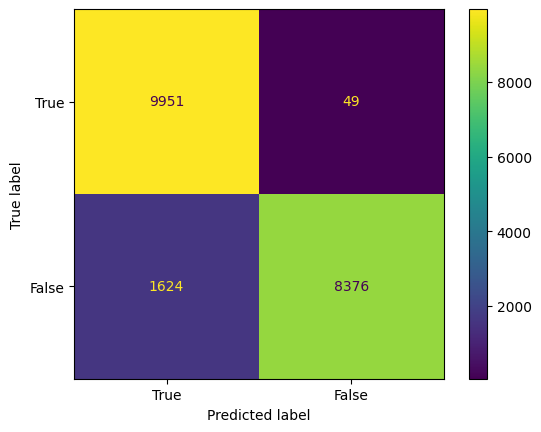

In [441]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
confusion_matrix = np.flip(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])

cm_display.plot()
plt.show()

In [442]:
fn = confusion_matrix[0][1]*100/confusion_matrix[0][0]
fn

0.4924128228318762

In [443]:
fp = confusion_matrix[1][0]*100/confusion_matrix[1][1]
fp

19.38872970391595

In [444]:
acc = metrics.accuracy_score(actual,predicted)
pre = metrics.precision_score(actual,predicted)
rec = metrics.recall_score(actual,predicted)
f1  = metrics.f1_score(actual,predicted)

print(f"Accuracy  = {acc:.4f}")
print(f"Precision = {pre:.4f}")
print(f"Recall    = {rec:.4f}")
print(f"F1        = {f1:.4f}")


Accuracy  = 0.9163
Precision = 0.8597
Recall    = 0.9951
F1        = 0.9225


In [445]:
score_p = []
score_n = []
for i in results:
    if i[0]:
        score_p.append(i[1])
    else:
        score_n.append(i[1])  

In [411]:
np.mean(score_p)

238.04443271212014

In [412]:
len(score_p)

138200

In [413]:
len(score_n)

5169

In [414]:
f_score_p = []
f_score_n = []

for i in score_p:
    if i<1000:
        f_score_p.append(i)

for i in score_n:
    if i<1000:
        f_score_n.append(i)

In [415]:
f_score_p = np.array(f_score_p)
f_score_n = np.array(f_score_n)


In [416]:
f_score_p.max()


991.9126

In [417]:
# Obtiene la información del histograma
valores_p, bordes_p = np.histogram(f_score_p, bins=100, density=True)
centros_p = 0.5 * (bordes_p[:-1] + bordes_p[1:])

# Encuentra el valor máximo en el eje Y
valor_maximo_y_p = max(valores_p)

# Encuentra el valor en el eje X para el cual Y es máximo
valor_maximo_x_p = centros_p[np.argmax(valores_p)]
valor_maximo_x_p

129.424207825

In [418]:
# Obtiene la información del histograma
valores_n, bordes_n = np.histogram(f_score_n, bins=100, density=True)
centros_n = 0.5 * (bordes_n[:-1] + bordes_n[1:])

# Encuentra el valor máximo en el eje Y
valor_maximo_y_n = max(valores_n)

# Encuentra el valor en el eje X para el cual Y es máximo
valor_maximo_x_n = centros_p[np.argmax(valores_n)]
valor_maximo_x_n

870.0922056249999

True

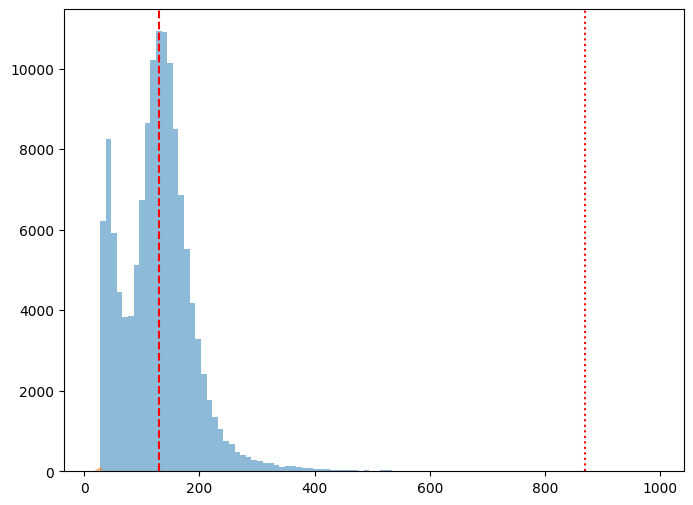

In [419]:
n_bins = 100


plt.figure(figsize=(8,6))
plt.hist(f_score_p, bins=100, alpha=0.5, label="data1", density=False)
plt.hist(f_score_n, bins=100, alpha=0.5, label="data1", density=False)
# Dibuja una línea vertical en el punto máximo
plt.axvline(x=valor_maximo_x_p, color='r', linestyle='--', label=f'Máximo en X: {valor_maximo_x_p:.2f}')
plt.axvline(x=valor_maximo_x_n, color='r', linestyle=':', label=f'Máximo en X: {valor_maximo_x_n:.2f}')

True